In [1]:
#Scikit-learn provides helper functions to download popular datasets, like the MNIST dataset, which is a collection of small images
#of digits drawn by high school students
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
#DESCR key describes the dataset, data key contains an array with one row per instance and one column per feature, target key contains an array with labels
x, y = mnist["data"], mnist["target"]
x.shape

(70000, 784)

In [4]:
y.shape

(70000,)

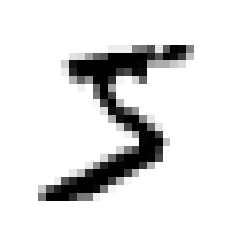

In [6]:
#Each image has 784 features, because each image is 28x28 pixels and each feature measures the pixel's intensity, from 0 (white) to
#255 (black). We can now peek at an image from the dataset
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = x[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [68]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [77]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:
#The labels are currently set to strings, so we can cast y to integers
import numpy as np
y = y.astype(np.uint8)

In [9]:
#The MNIST dataset is already split into a training set and a test set
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

In [10]:
#We will begin with a binary model to determine if a given image is a 5 or not
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
#We will start with stochastic gradient descent, which can handle large datasets very efficiently
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

In [16]:
#Performance Measures: Cross Validation
#The StratifiedKFold class performs stratified sampling which will produce folds that contain a representative ratio of each class
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/Users/evanwireman/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


In [17]:
#We can use the cross_val_score() function to evaluate our SGDClassifier model
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [20]:
#Lets look at a really simplistic dumb classifier that can get similar accuracy
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [23]:
#We get accurate results because, since only 10% of the dataset is 5's, always guessing not 5 will result in mostly accurate predictions
#This is why accuracy is generally not the performed performance measure for classifiers

#We can use a confusion matrix instead, but we need to generate predictions for the confusion matrix to analyze
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [25]:
#Each row in the confusion matrix represents an actual class, while each column represents a predicted class. The first row
#of the matrix above considers non-5 images (the negative class). We correctly predicted 53892 of these non-5's (true negatives) while the remaining 687 were
#falsely classified as 5's (false positives). The second row considers images that are 5's (the positive class). 1891 were wrongly classified
#as not-5 (false negative), while the remaining 3530 were correctly classified as 5's (true positives).

#We can use this information to calculate percision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [26]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [27]:
#We can interpret these results as: when our classifier claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects
#75.6% of the 5's. We can combine percision and recall and find the F score, which makes it simple to compare 2 classifiers. The F score is the harmonic
#mean of precision and recall, where low values are given more weight in the calculation of the average.
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [28]:
#The way that the SGD algorithm works is that it computes a score for each decision it makes, and if that score is greater than a threshold,
#it assigns the instance to the positive class, and vice verca for the negative class. Scikit-learn does not let you edit the threshold directly,
#but it does give you access to the decision scores that it uses to make predictions. We can then manually use any threshold we want.
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [30]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [31]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [33]:
#Can use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that
#we want the decision scores instead of the predictions
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method="decision_function")

In [34]:
#With these scores we can calculate the precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

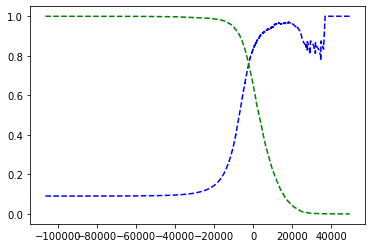

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [37]:
#Suppose we are aiming for 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [39]:
#To make predictions, we can now run this code
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [40]:
#Let's check these predictions precision and recall
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [41]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [42]:
#This is great, but the 90% precision came at the cost of a small recall.

#The ROC curve is another common tool used with binary classifiers. It plots true positive rates vs false positive rates.
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

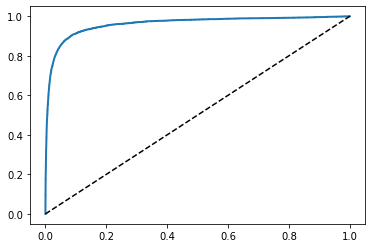

In [43]:
#Then you can plot FPR vs TPR using Matplotlib
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

In [44]:
#One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have an area under the curve equal to 1, whereas a purely
#random classifier will have an area under the curve of 0.5
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [45]:
#Let us now train a RandomForestClassifier and compare ROC curves and ROC AUC scores. However, RandomForestClassifier does not have a
#decision_function() method, it instead has a predict_proba() method, which returns an array containing a row
#per instance and a column per class, each containing the probability that the given instance belongs to the given class.
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method="predict_proba")

In [46]:
#You can give the roc_curve() probabilities, so we can feed it the positive class' probabilities
y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

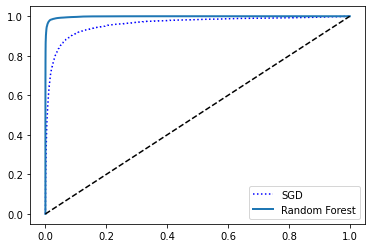

In [47]:
#Now we can plot the ROC curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [48]:
#As you can see, the random forest classifier's ROC curve looks much better than the SGDClassifier's. Thus the ROC AUC score is better too
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# That is it for binary classifiers, we will now delve into multiclass classification

There are 2 real types of multiclass classifiers: OvR and OvO. OvR classifiers (one versus the rest) work on the premise that you train, in our case, 10 binary classifiers (one for each digit), get a decision score from each classifier, and select the class whose classifier outputs the highest score. OvO classifiers (one versus one) work on the premise that you train a binary classifier for each pair of digits, so one to distinguish between 0s and 1s, one to distinguish vs 0s and 2s, etc.

OvO classification is prefered for classifiers who scale poorly with training data size, such as support vector machines. In most cases, OvR is preferred.

In [50]:
#Scikit-learn detects when you try to use binary classification for a multiclass classification task, and it will automatically run OvR or OvO depending on
#the algorithm. Let's first try a SVM classifier
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(x_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [51]:
#We can tell that the SVM is using a OvO approach when we call the decision_function(), which will return 10 scores per instance instead of one
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [52]:
#The highest score is indeed the one corresponding to class 5
np.argmax(some_digit_scores)

5

In [53]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [54]:
svm_clf.classes_[5]

5

In [56]:
#You can force Scikit-Learn to use OvO or OvR. There are two classes, OneVsOneClassifier and OneVsRestClassifier, that you can pass a classifier constructor into.
#Here we will look at an OvR strategy, based on a SVC
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(x_train, y_train)

In [ ]:
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

In [57]:
#Training a SGDClassifier is just as easy
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [58]:
#This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers can directly classify instances into multiple classes. The decision_function()
#method now returns one value per class
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [59]:
#This classifier is pretty confident in its prediction, almost all scores are negative except 5, which is largely positive. We can now
#evaluate this classifier with cross_val_score()
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [61]:
#This is good, however we can make it more accurate by simply scaling the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [62]:
#Let's assume that SGD is a good enough model. We can fine tune it with the confusion matrix
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

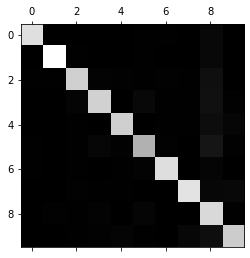

In [63]:
#This is hard to look at, but we can see an image representation using Matplotlib's matshow() function
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [64]:
#This seems pretty good, although the 5's seem darker than the other digits. This means that either therre was simply fewer 5's in the dataset,
#or the classifier does not perform as well on 5's as other digits. We can verify that both are the case.

#Let's focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class
#so that you can compare error rates instead of absolute numbers of errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

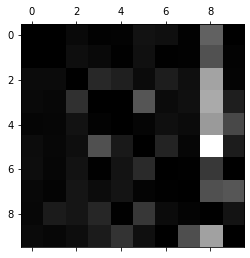

In [65]:
#Now fill the diagonal with seros to keep only the errors, and plot the result
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

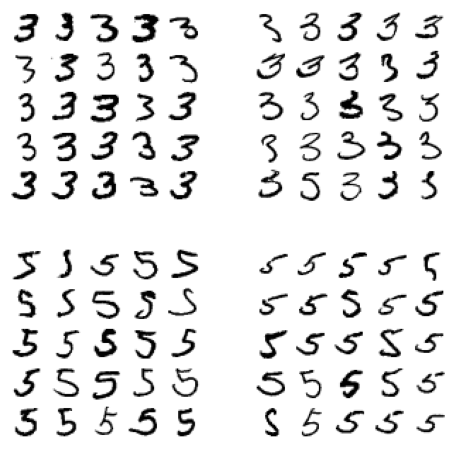

In [70]:
#You can clearly see now what type of errors the classifier makes. Remember that rows represent actual classes while columns represent
#predicted classes. The column for class 8 is bright, meaning many things get misclassified as 8s. Also, 3s and 5s often get
#confused in both directions.

#Analyzing individual errors can be a good way to gain insights on what your classifier is doing and why it is failing. For example, lets
#plot examples of 3s and 5s

cl_a, cl_b = 3, 5
x_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(x_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(x_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(x_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(x_bb[:25], images_per_row=5)
plt.show()

In [71]:
#The two 5x5 blocks on the left show digits classified as 3s, and the two blocks on the right show images classified as 5s.
#The confusion stems from the fact that 3s and 5s are relatively similar, only a few pixels separate a 3 from a 5. One way to 
#increase the model's accuracy in these instances would be to have the preprocessing ensure that the images are well centered and not
#too rotated.

# Multilabel Classification

This is when you want the classifier to notice multiple things in one instance. For example, recognizing multiple faces in one image.

In [72]:
#We can look at a simple example here
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier()

In [73]:
#This will create a model trained to recognize whether a number is odd or not, and also whether it is large (>= 7)
knn_clf.predict([some_digit])

array([[False,  True]])

In [75]:
#There are many ways to evaluate a multilabel classifier, one approach is to calculate the F1 score for each individual
#label and then simply compute the average score
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel,  cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [76]:
#This assumes that all labels are equally important. That may not necesarily be the case, and when its not, a simple option is
#to give each label a weight equal to its support (the number of instances with that target label). To do this,
#simply set average="weighted" in the preceeding code

# Multioutput Classification

This is simply a generalization of multilabel classification, where each label can be a multiclass (i.e. can have more than 2 possible values.

To illustrate this, we can build a system that removes noise from the images. It will take as input a noisy digit image and hopefully output a clean digit image, represented as an array of pixel intensities just like the MNIST images. Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system.

In [78]:
#Let's start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities 
#with NumPy's randint() function. The target images will be the original images.

noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

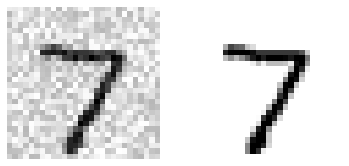

In [80]:
#Let's compare a noisy image to the original
some_index = 0
plt.subplot(121); plot_digit(x_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

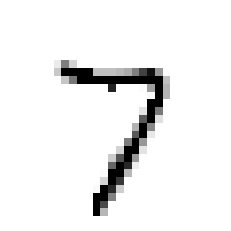

In [81]:
#Now we can train the classifier and make it clean this image
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_test_mod[some_index]])
plot_digit(clean_digit)

# That's it for classification!